# Dataset for Binary Classification 

X_train.shape (800, 2)
X_test.shape (200, 2)


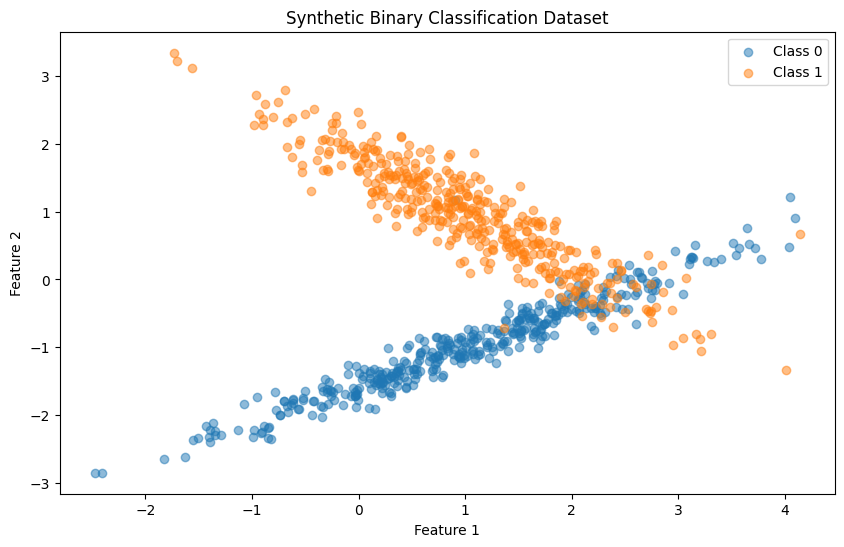

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, train_test_split


# Generate a simplistic synthetic dataset with binary classes
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=42, n_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

# Plot the synthetic dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', alpha=0.5)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Binary Classification Dataset')
plt.legend()
plt.show()


# Learning Curves 

In [23]:
__num_train_epochs=1
__per_device_train_batch_size=2
__per_device_eval_batch_size=2
__weight_decay=0.1

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Function to calculate learning curve
def learning_curve_nn(model, X, y, cv, train_sizes):
    train_scores = []
    val_scores = []

    train_scores_std = []
    val_scores_std = []
    # Outer loop: Iterate over different training sizes
    # 10 iterations
    for train_size in train_sizes:
        # Sample the training set according to the current size
        subset_indices = np.arange(int(train_size * len(X)))
        subset = Subset(TensorDataset(X, y), subset_indices)

        train_score = []
        val_score = []
        
        # Cross-validation loop: Split the data into training and validation sets
        # 10 * 10 = 100 iterations
        for train_index, test_index in cv.split(subset_indices, y.numpy()[subset_indices]):  # cv.n_splits iterations
            # Creating the training and validation subsets for the current split
            train_dataset = Subset(subset, train_index)
            val_dataset = Subset(subset, test_index)
            
            train_loader = DataLoader(train_dataset, batch_size=__per_device_train_batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=__per_device_eval_batch_size, shuffle=False)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=__weight_decay)

            # Training loop: Train the model for 50 epochs
            # 100 * 50 = 5000 iterations
            for epoch in range(__num_train_epochs):
                # Set the model to training mode
                model.train()
                # len(train_loader) iterations
                # For Train Size 0.1: Subset size = 0.1 * size(X_train) = 0.1 * 800 = 80
                #                     and Number of batches = ceil(80 / 32 = 2.5) = 3
                #                     len(train_loader) = 3
                # For Train Size 0.2: Subset size = 0.2 * size(X_train) = 0.2 * 800 = 160
                #                     and Number of batches = ceil(160 / 32 = 5) = 5
                #                     len(train_loader) = 5
                # ...
                # For Train Size 1.0: Subset size = 1.0 * size(X_train) = 1.0 * 800 = 800
                #                     and Number of batches = ceil(800 / 32 = 25) = 25
                #                     len(train_loader) = 25
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
            # Set the model to evaluation mode
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                # len(train_loader) iterations
                for X_batch, y_batch in train_loader:
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()  # Number of correct predictions
            train_score.append(correct / total)  # Append training accuracy

            correct = 0
            total = 0
            with torch.no_grad():
                # len(val_loader) iterations
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()  # Number of correct predictions
            val_score.append(correct / total) # Append validation accuracy
        
        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))
        train_scores_std.append(np.std(train_score))
        val_scores_std.append(np.std(val_score))

    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    train_scores_std = np.array(train_scores_std)
    val_scores_std = np.array(val_scores_std)
    
    return train_sizes, train_scores, val_scores, train_scores_std, val_scores_std


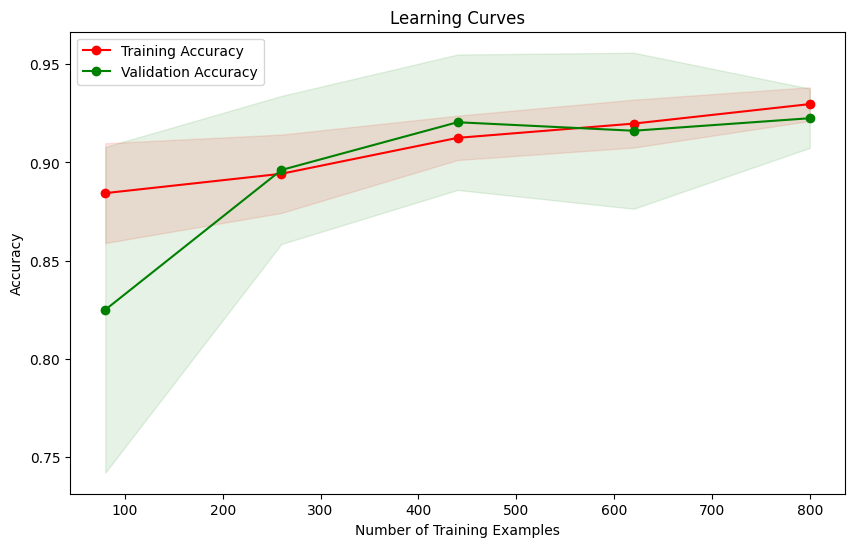

In [25]:
# Create a neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Define cross-validation and training sizes
cv = StratifiedKFold(n_splits=5)
train_sizes = np.linspace(0.1, 1.0, 5)  # Training set sizes from 10% to 100%

train_sizes, train_scores, val_scores, train_scores_std, val_scores_std = learning_curve_nn(SimpleNN(),
                                                                                           X_train_tensor,
                                                                                           y_train_tensor,
                                                                                           cv,
                                                                                           train_sizes)

# Plotting the learning curves with standard deviations
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes * len(X_train), train_scores - train_scores_std,
                 train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes * len(X_train), val_scores - val_scores_std,
                 val_scores + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label='Training Accuracy')
plt.plot(train_sizes * len(X_train), val_scores, 'o-', color="g", label='Validation Accuracy')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()
